In [20]:
import cv2
import os
import numpy as np
import matplotlib
import tkinter
import matplotlib.pyplot as plt
matplotlib.use('TkAgg')
%matplotlib inline 

import pyrealsense2 as rs                 # Intel RealSense cross-platform open-source API
from stretch_body.robot import Robot
from scipy.spatial.transform import Rotation
from re1_utils.camera import get_cur_rs_frame, get_rs_colorized_depth


In [21]:

import sys
sys.path.append('./yolov7/')

from yolov7.predict import load_model, preprocessing, \
    postprocessing, load_config

**Object Detection**: From yolov7

In [22]:
#Load config from yaml
CONFIG_PATH = './yolov7/predict_config.yaml'
config_dict = load_config(CONFIG_PATH)

#Load model, edit yolov7.pt path
model, stride, device = load_model(config_dict, '../yolov7/yolov7.pt')


[INFO] [utils.torch_utils]: YOLOR 🚀 a0bbdb1 torch 1.12.1+cu102 CPU



Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block


[INFO] [utils.torch_utils]: Model Summary: 306 layers, 36905341 parameters, 36905341 gradients


In [23]:
#Read img0 to BGR
img0 = cv2.imread('./yolov7/inference/images/image1.jpg')

#Resize, pad
img = preprocessing(config_dict, img0, stride, device) 

#Inference
pred = model(img, augment=config_dict['augment'])[0] #Shape (1, num_preds, 85)

#nms and scale coordinates
pred = postprocessing(config_dict, pred, img0.shape, img.shape)

#xyxy, conf_score, class
print(pred, pred.shape)

[[        250          78         633         531     0.96753           0]
 [          2           5         402         527     0.95566           0]
 [        196         199         254         418     0.88187          27]
 [        256         207         299         247     0.42756          55]] (4, 6)


In [24]:
color_frame, color, depth_frame, depth = get_cur_rs_frame()

Frames Captured


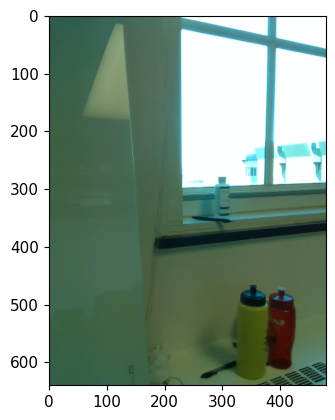

In [25]:
plt.imshow(color)
plt.show()

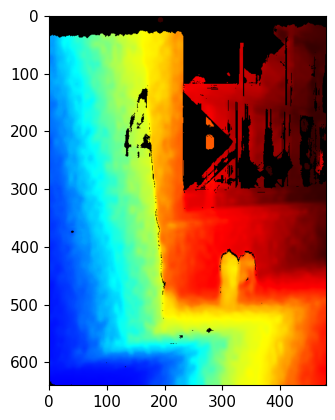

In [38]:
colorized_depth = get_rs_colorized_depth(depth_frame=depth_frame)
plt.imshow(colorized_depth)
plt.show()

In [28]:
sys.path.append('..')


In [29]:
from POI.object_of_interest import OOI
all_objects = []
for i in range(pred.shape[0]):
    coord = pred[i, :]
    obj = OOI(
        img_coord = np.array([(coord[2]-coord[0])/2,(coord[3]-coord[1])/2]), 
        depth = 0,
        obj_class = int(coord[-1]),
        obj_atributes = 'None', 
        bbox = ((coord[0],coord[1]),(coord[2],coord[3])),
        conf_score = coord[4],
        eid = i
    )
    all_objects.append(obj)

*Taken from fairo tutorial and memory module


**Memory**

Now we have setup a small object detection + deduplication pipeline.

But the robot is not storing the information of these objects in it's memory yet.

If it doesn't store this information in memory, then when you say "go to the chair", it does not know where the chair is (unless the chair is in it's field of view at that given moment).

`droidlet` provides a memory system that can store generic metadata. This memory system is used by the Dialog Parser + Task controller to do tasks utilizing context provided by information stored in memory.

The memory is backed by an SQL database, and has schemas to represent common semantic information for robots and the environment.

Let us first create the default `AgentMemory` object for our Locobot using some pre-baked and thoughtful memory schemas.

In [30]:
sys.path.append('./memory/')


In [31]:
from memory.sql_memory import AgentMemory
from memory.robot.loco_memory_nodes import NODELIST

SQL_SCHEMAS = [
    os.path.join(os.getcwd(), "memory", "base_memory_schema.sql"),
    os.path.join(os.getcwd(), "memory", "robot","loco_memory_schema.sql"),
]

In [32]:
memory = AgentMemory(db_file=":memory:", schema_paths=SQL_SCHEMAS, nodelist=NODELIST)

We can see the types of nodes that can be stored inside the memory

In [33]:
memory.nodes

{'Task': memory_nodes.TaskNode,
 'Chat': memory_nodes.ChatNode,
 'Location': memory_nodes.LocationNode,
 'Attention': memory_nodes.AttentionNode,
 'Triple': memory_nodes.TripleNode,
 'Interpreter': memory_nodes.InterpreterNode,
 'Set': memory_nodes.SetNode,
 'Time': memory_nodes.TimeNode,
 'Player': memory_nodes.PlayerNode,
 'Self': memory_nodes.SelfNode,
 'Program': memory_nodes.ProgramNode,
 'NamedAbstraction': memory_nodes.NamedAbstractionNode,
 'ReferenceObject': memory_nodes.ReferenceObjectNode,
 'DetectedObject': memory.robot.loco_memory_nodes.DetectedObjectNode,
 'HumanPose': memory.robot.loco_memory_nodes.HumanPoseNode,
 'Dance': memory.robot.loco_memory_nodes.DanceNode,
 'BCIDetectedObject': memory.robot.loco_memory_nodes.BCIDetectedObjectNode}

Let us store the previously detected objects into memory, using this new memory system.

For this, we will use the DetectedObjectNode. A physical object is represented in memory as a DetectedObjectNode, which is thoughtfully annotated with properties such as it's color and it's detected xyz location.

As a reminder, in the previous section, we deduplicated the objects detected in the scene, and stored them in the variable previous_objects.

Now, we will store these all_objects into the memory. Let us start with storing and retreiving one object, and inspecting the results.

In [34]:
# from memory.robot.loco_memory_nodes import Detect
from memory.robot.loco_memory_nodes import BCIDetectedObjectNode


In [35]:
memory_ids = []
for i in range(len(all_objects)):
    memory_id = BCIDetectedObjectNode.create(memory, all_objects[i])
    memory_ids.append(memory_id)

0
1
2
3


Now, let us retreive the `DetectedObjectNode` from memory.

In [36]:
memory.get_mem_by_id(memory_id)

DetectedObject id 3, pos (0.0, 0.0, 0.0)

The memory object is in it's raw packed form, and is not yet converted back to a dict with accessible fields.

We can access the detected objects back from memory as dicts using the `get_all` function:

In [37]:
BCIDetectedObjectNode.get_all(memory)

Now, let us store the rest of the detected objects into memory